# BBH formation channels with Gaussian mixture
#### Tasks

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

2) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. This is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in scientific research!

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in detail.

4) For each of this fits, compute the AIC (easy! It's a attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

6) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`: you'll need them both. Try to understand what they do and how you can put them together.

Text(0.5, 0, 'Mass [$M_{\\odot}$]')

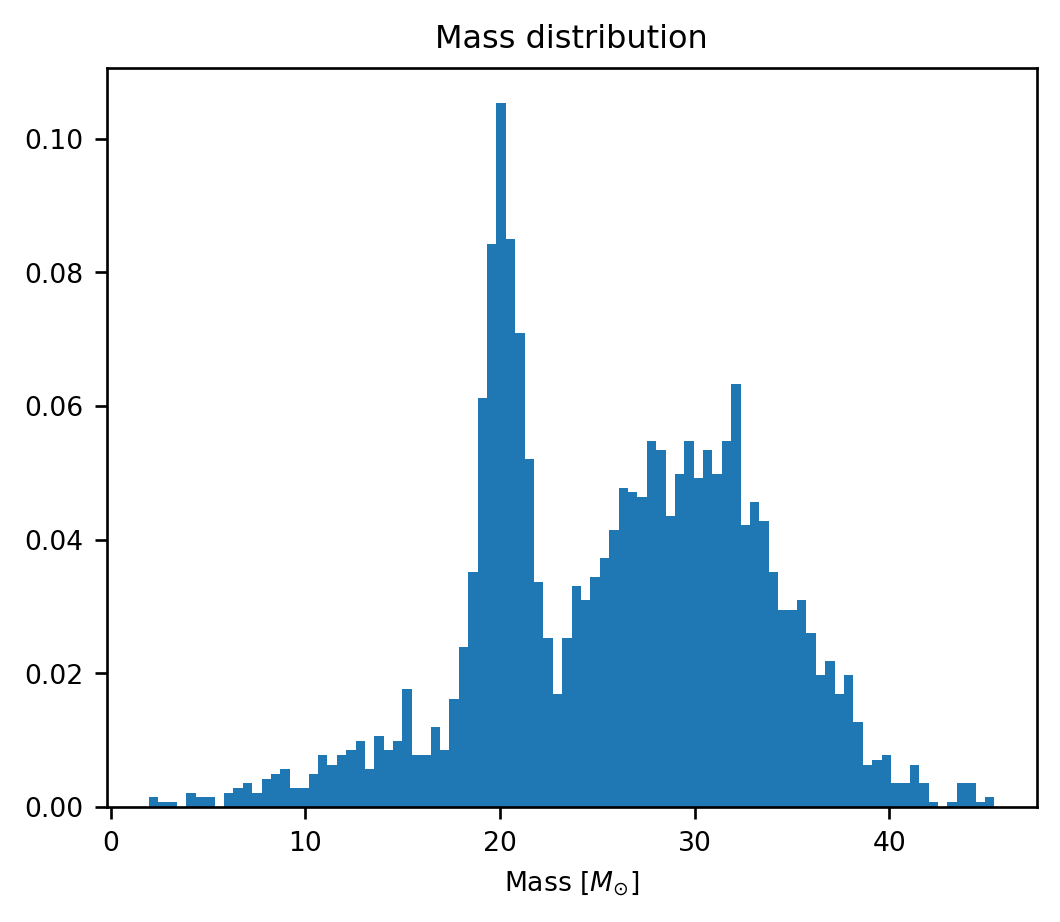

In [37]:
import numpy as np
import pylab as plt
from astroML.utils.decorators import pickle_results

#-------  Plt params  ----------------
plt.rc('figure', figsize=(5, 4), dpi=120)
plt.rcParams.update({'font.size': 8})
#--------------------------------------------

from sklearn.mixture import GaussianMixture

data = np.load('../solutions/formationchannels.npy') # 2950 BH masses

a = plt.hist(data, bins=90, density=True)
plt.title('Mass distribution')
plt.xlabel(r'Mass [$M_{\odot}$]')


In [15]:
seed = 404

# @pickle_results('gaussian_mixture.pkl')
def gen_mix(n_list):
    gauss_mix = []
    for n in n_list:

        args = dict(
            n_components = n,
            # covariance_type = 'spherical',
            # init_params = 'random' ,
            random_state = seed,
            n_init = 10 #_______ needed to actually work
        )

        gauss_mix.append(GaussianMixture(**args))
    return gauss_mix

n_list = np.arange(1,11)
gauss_mix = gen_mix(n_list)


@pickle_results: using precomputed results from 'gaussian_mixture.pkl'


In [17]:
# @pickle_results('fitted_gaussian_mixture.pkl') #why always args match: False?
def fit_mixture(gauss_mix):
    fitted = []
    for mix in gauss_mix: 
        fitted.append(mix.fit(data))
    return fitted

gauss_fit = fit_mixture(gauss_mix)


@pickle_results: computing results and saving to 'fitted_gaussian_mixture.pkl'
    - args match:   False
    - kwargs match: True


Text(0.5, 1.0, 'BIC')

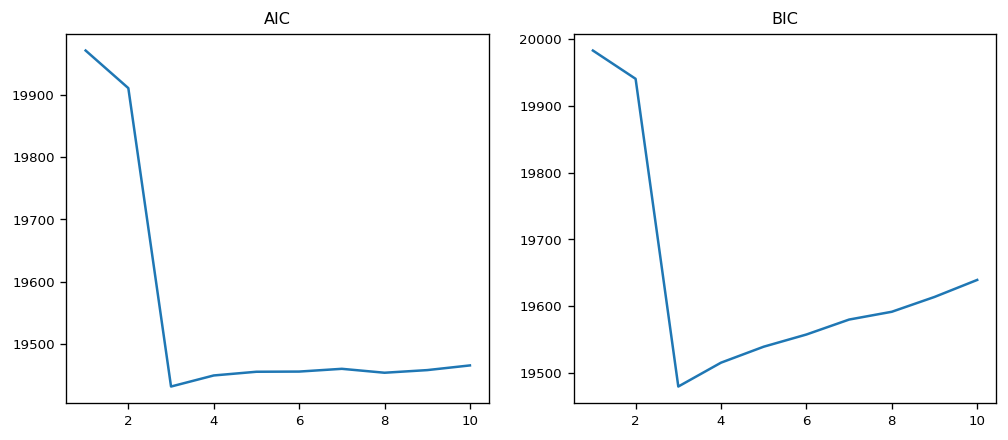

In [18]:
aic = [mix.aic(data) for mix in gauss_fit]
bic = [mix.bic(data) for mix in gauss_fit]

#-------  Plt params  ----------------
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 8})
#--------------------------------------------

fig, ax = plt.subplots(1,2)
ax[0].plot(n_list,aic)
ax[0].set_title('AIC')

ax[1].plot(n_list,bic)
ax[1].set_title('BIC')

We see that the minimum is at n = 3

Text(0.5, 0, 'Mass [$M_{\\odot}$]')

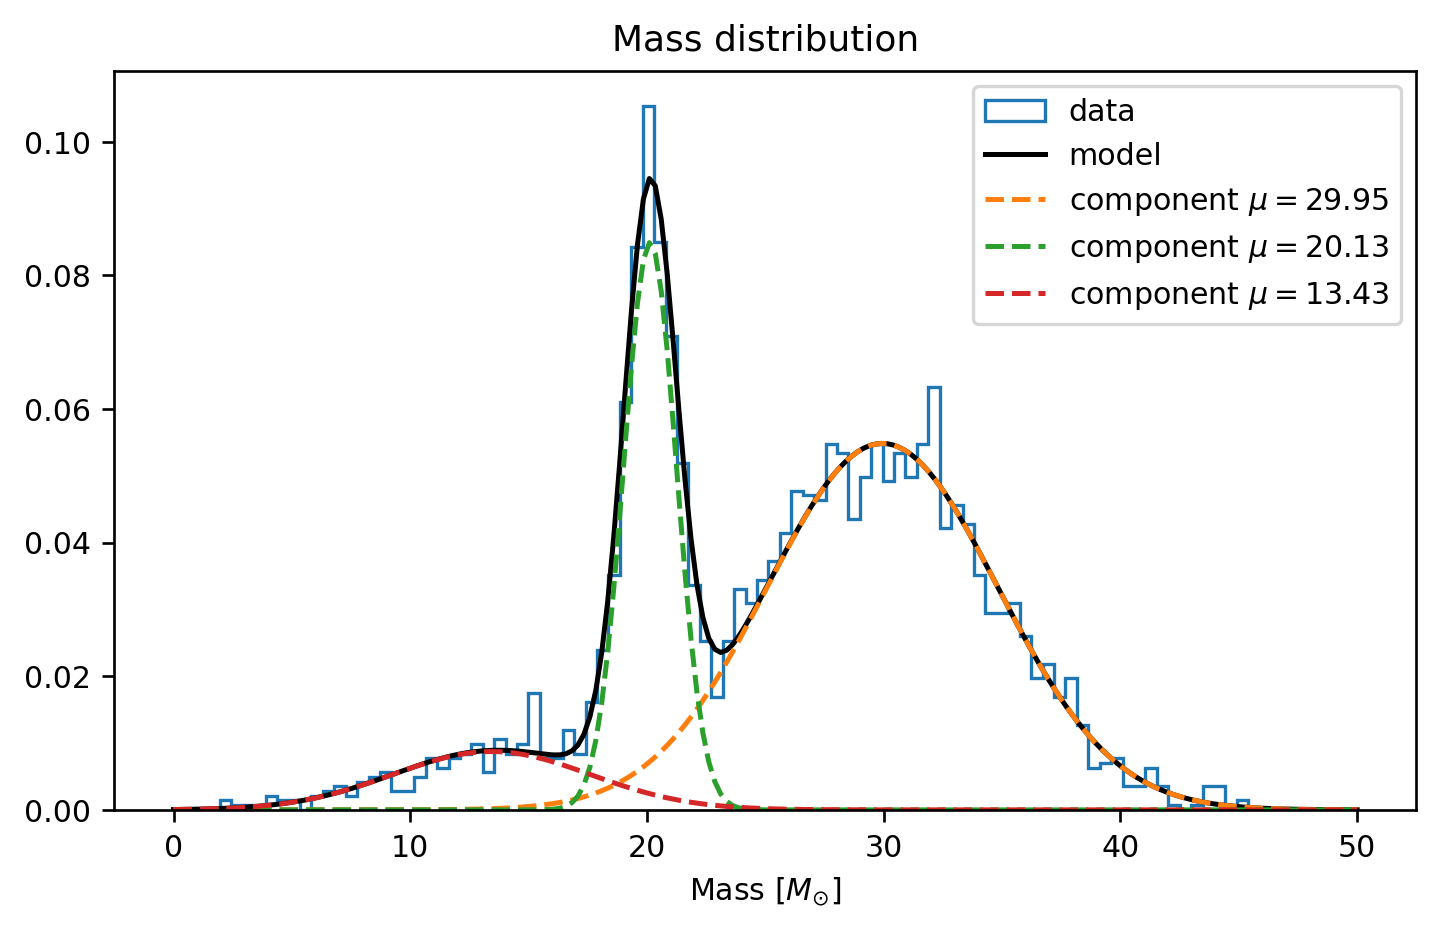

In [38]:
from scipy.stats import norm
mix_best = gauss_fit[n_list[np.argmin(aic)-1]]

x_grid = np.linspace(0,50,200)
logl = mix_best.score_samples(x_grid[:,np.newaxis])
prob = np.exp(logl)

means = mix_best.means_
weights = mix_best.weights_
sigmas = np.sqrt(mix_best.covariances_)

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(7, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

plt.hist(data, bins=90, density=True, histtype='step', label='data')
plt.plot(x_grid,prob, c='k', label='model')

for a, mu, sigma in zip(weights,means[:,0],sigmas[:,0,0]):
    dist = norm(loc=mu, scale=sigma).pdf
    plt.plot(x_grid, a*dist(x_grid), ls='--', label=f'component $\mu = {mu:.4}$')

plt.legend()
plt.title('Mass distribution')
plt.xlabel(r'Mass [$M_{\odot}$]')

In [39]:
resp = mix_best.predict_proba(x_grid[:,np.newaxis])